# Machine Learning Programming Exercise 8: Anomaly Detection

In [1]:
#import package(s)
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio 
import scipy.stats
from sklearn.metrics import f1_score
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

## 1 Anomaly detection
This exercise implements an anomaly detection algorithm to detect anomalous behavior in server computers to identity failing servers on a network. The features measure the through-put (mb/s) and latency (ms) of response of each server. While the servers were operating, there were $m = 307$ examples collected of how they were behaving, resulting in an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. It is suspected that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset. 

Use a Gaussian model to detect anomalous examples in the dataset. Start on a 2D dataset to visualize what the algorithm is doing. On that dataset fit a Gaussian distribution and then ﬁnd values that have very low probability and hence can be considered anomalies. After that, apply the anomaly detection algorithm to a larger dataset with many dimensions.

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
   Some applications of anomaly detection are 
   * identifying users behaving strangely (user behavior anomaly detection/fraud detection)
   * quality assurance testing on manufactured products
   * monitoring computers' behavior in a data center
   
</div>

Visualizing example dataset for outlier detection.


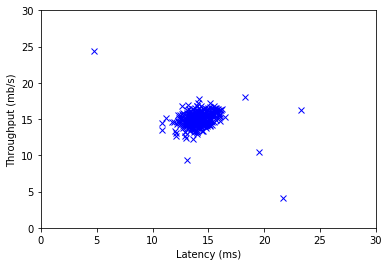

In [2]:
# ================== Part 1: Load Example Dataset  ===================
#  We start this exercise by using a small dataset that is easy to
#  visualize.

#  Our example case consists of 2 network server statistics across
#  several machines: the latency and throughput of each machine.
#  This exercise will help us find possibly faulty (or very fast) machines.

print('Visualizing example dataset for outlier detection.')

#The following command loads the dataset. You should now have the
#variables X, Xval, yval in your environment
data = sio.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

#Visualize the example dataset
plt.figure()
plt.plot(X[:,0], X[:,1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
   When choosing or creating features, 
   * it might help to use transformations to make the features look more Gaussian before feeding it into the learning algorithm
   * think about how to capture different types of anomalies by trying unusual combinations of values of the features that would make it distinguishable from the normal examples
</div>

### 1.1 Gaussian distribution
To perform anomaly detection, first fit a model to the data’s distribution.

Given a training set $\{x^{(1)}, \dots, x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), estimate the Gaussian distribution for each of the features $x_i$. For each feature $i=1,\dots,n,$ find parameters $\mu_i$ and $\sigma_i^2$ that fits the data in the
$i$-th dimension $\{x_i^{(1)}, \dots, x_i^{(m)}\}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by
$\begin{align*} p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}, \end{align*}$
where $\mu$ is the mean and $\sigma^2$ controls the variance.

### 1.2 Estimating parameters for a Gaussian
Estimate the parameters, $(\mu_i,\sigma_i^2)$, of the $i$-th feature by using the following equations. To estimate the mean, use: $\begin{align*} \mu_i = \frac{1}{m}  \sum_{j=1}^m x_i^{(j)}, \end{align*}$
and for the variance use: $\begin{align*} \sigma_i^2 = \frac{1}{m}  \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2. \end{align*}$

Complete the code in estimateGaussian. This function takes as input the data matrix $X$ and should output an $n$-dimension vector $mu$ that holds the mean of all the $n$ features and another $n$-dimension vector $sigma2$ that holds the variances of all the features. This can be implemented using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient.

Once the code is completed, a plot will visualize the contours of the fitted Gaussian distribution. From the plot, it can be seen that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

Visualizing Gaussian fit.


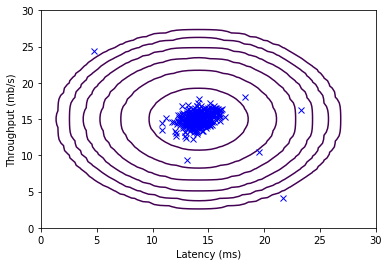

In [3]:
#define function for exercise(s)
def estimateGaussian(X):
#ESTIMATEGAUSSIAN This function estimates the parameters of a 
#Gaussian distribution using the data in X
#   [mu sigma2] = estimateGaussian(X), 
#   The input X is the dataset with each n-dimensional data point in one row
#   The output is an n-dimensional vector mu, the mean of the data set
#   and the variances sigma^2, an n x 1 vector
    
    #compute the mean of each column
    mu = np.mean(X, axis=0)
    #compute the variance of each column
    var = np.var(X, axis=0)
    return mu, var
    
def multivariateGaussian(X, mu, sigma2):
#MULTIVARIATEGAUSSIAN Computes the probability density function of the
#multivariate gaussian distribution (joint PDF of the individual Gaussian(mu,sigma))
#    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
#    density function of the examples X under the multivariate gaussian 
#    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
#    treated as the covariance matrix. If Sigma2 is a vector, it is treated
#    as the \sigma^2 values of the variances in each dimension (a diagonal
#    covariance matrix

    covariance = np.diag(sigma2)
    p = scipy.stats.multivariate_normal.pdf(X, mean=mu, cov=covariance)
    return p
    #you can compute the individual Guassians and then multiply them to get the joint PDF
    
def visualizeFit(X, mu, sigma2):
#VISUALIZEFIT Visualize the dataset and its estimated distribution.
#   VISUALIZEFIT(X, p, mu, sigma2) This visualization shows you the 
#   probability density function of the Gaussian distribution. Each example
#   has a location (x1, x2) that depends on its feature values.

    plt.figure()
    X1, X2 = np.meshgrid(np.linspace(0, 35, 70), np.linspace(0, 35, 70))
    xy = np.column_stack([X1.flat, X2.flat])
    Z = multivariateGaussian(xy, mu, sigma2)
    Z = Z.reshape((X1.shape))
    
    plt.contour(X1, X2, Z, np.logspace(-20, 0, 7))
    plt.plot(X[:,0], X[:,1], 'bx')
    
# ================== Part 2: Estimate the dataset statistics ===================
#  For this exercise, we assume a Gaussian distribution for the dataset.

#  We first estimate the parameters of our assumed Gaussian distribution, 
#  then compute the probabilities for each of the points and then visualize 
#  both the overall distribution and where each of the points falls in 
#  terms of that distribution.

print('Visualizing Gaussian fit.')

#Estimate mu and sigma2
mu, sigma2 = estimateGaussian(X)

#Returns the density of the multivariate normal at each data point (row) 
#of X
p = multivariateGaussian(X, mu, sigma2)

#Visualize the fit
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.axis([0, 30, 0, 30])
plt.show()

THe image above shows the Gaussian distribution contours of the distribution fit to the dataset.

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
   Steps of the anomaly detection algorithm 
   1. Choose or come up with features $x_i$ that might be indicative of anomalous examples, but also describe general properties of the collected data
   2. Fit the parameters $\mu_1, \dots, \mu_n, \sigma_1^2, \dots, \sigma_n^2$ to a training set of $M$ unlabelled examples 
   3. Calculate the probability of the new example, $p(x)$. Flag it as an anomaly if $p(x) < \epsilon$
   
The anomaly detection algorithm can be modified to use the **multivariate Gaussian (Normal) distribution** as the probability model. To use this model, it is required that the number of examples is greater than the number of features. Else, the covariance matrix $\Sigma$ is non-invertible. 
   
It has the advantage of automatically capture correlations between different features whereas the original model capture anomalies through the manually creation of features that can take unusually values. Yet, if there are a large number of features, it can be computationally expensive to compute the inverse of the covariance matrix
</div>

### 1.3 Selecting the threshold, $\epsilon$
After estimating the Gaussian parameters, investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in the dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set. 

Using a cross validation set $\{(x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, the label $y=1$ corresponds to an anomalous example and $y=0$ corresponds to a normal example. For each cross validation example, compute $p(x_{cv}^{(i)})$. The vector of these probabilities $p(x_{cv}^{(1)}), \dots, p(x_{cv}^{(m_{cv})})$ are passed into the vector $pval$. The corresponding labels $y_{cv}^{(1)}, \dots, y_{cv}^{(m_{cv})}$ is passed into the vector $yval$.

If an example $x$ has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The $F_1$ score tells you how well you’re doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$): $\begin{align*} F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}. \end{align*}$ Compute precision and recall using $\begin{align*} prec = \frac{t_p}{t_p + f_p} \end{align*}$ and $\begin{align*} rec = \frac{t_p}{t_p + f_n} \end{align*},$ where
* $t_p$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly. 
* $f_p$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* $f_n$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

Try many different values of $\epsilon$ and select the best one based on the $F_1$ score. Implement the computation of the F1 score over all the cross validation examples (to compute the values $t_p, f_p, f_n ).$ The value for $\epsilon$ should be 8.99e-05.

Run the anomaly detection code and see the anomalies are circled in the plot.

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
   I could not get the selectThreshold function to calculate $t_p, f_p, f_n$, so I used the tutorial created by [Aaqib Saeed](https://aqibsaeed.github.io/2016-07-17-anomaly-detection/) to select the best $F_1$ score and $\epsilon$.
</div>


Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of 0.875000)


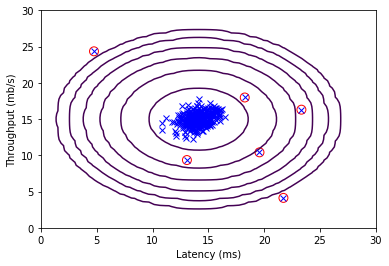

In [4]:
#define function for exercise(s)
def selectThreshold(yval, pval):
#SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
#outliers
#   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
#   threshold to use for selecting outliers based on the results from a
#   validation set (pval) and the ground truth (yval).
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), stepsize):
        preds = pval < epsilon
        F1 = f1_score(yval, preds, average="binary")
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    return bestEpsilon, bestF1


# ================== Part 3: Find Outliers ===================
#  Now you will find a good epsilon threshold using a cross-validation set
#  probabilities given the estimated Gaussian distribution

pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('\nBest epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of 0.875000)')

#indexes of the values considered to be outliers
outliers = np.where(p < epsilon)

# Draw a red circle around those outliers
visualizeFit(X, mu, sigma2)
plt.scatter(X[outliers, 0], X[outliers, 1], s=80, facecolors='none', 
         edgecolors='r')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.axis([0, 30, 0, 30])
plt.show()

Above, the algorithm classified the anomalies. 

<div class="alert alert-block alert-info">
<b>Note:</b> 
    
   Steps to evaluating an anomaly detection algorithm
   1. Fit the model $p(x)$ to the training set $\{x^{(1)}, \dots, x^{(m)}\}$
   2. Given an example $x$ from the cross validation, predict whether $y$ is anomalous ($p(x) < \epsilon$) or not ($p(x) \geq \epsilon$)
   3. Use a good evaluation metric to determine how often the algorithm is getting the labels right. Since the data is very skewed (y equals zero becomes much more common), classification accuracy would not be a good the evaluation metric.
       * True/false positives, true/false negatives
       * Precision/Recall
       * $F_1$ score
   4. Pick the $\epsilon$ that does well on the cross validation set
   5. Use the test set for the final evaluation of the algorithm
   
</div>

### 1.4 High dimensional dataset

The last part of the code runs the anomaly detection algorithm on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of the compute servers. 

The script will use the code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data $X$ from which the Gaussian parameters were estimated, and for the cross-validation set $Xval.$ The code will then ﬁnd the best threshold $\epsilon$. This value should be about 1.38e-18 and 117 anomalies found.

In [5]:
# ================== Part 4: Multidimensional Outliers ===================
#  We will now use the code from the previous part and apply it to a 
#  harder problem in which more features describe each datapoint and only 
#  some features indicate whether a point is an outlier.

#Loads the second dataset. You should now have the
#variables X, Xval, yval in your environment
data = sio.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

#Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#Training set 
p = multivariateGaussian(X, mu, sigma2)

#Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('\nBest epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: %d' % sum(p < epsilon))
print('   (you should see 117 anomalies)')


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set: 0.615385
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117
   (you should see 117 anomalies)
